In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
from scipy import signal
from numpy import linalg

In [3]:
import mne

# Loading, filtering and extracting data

In [4]:
raw = mne.io.read_raw_edf('data/Dual_Aural.edf', preload=True)

Extracting EDF parameters from /home/delta_c/EnW/Biotech_Researches/EEG_Event_Classification-1/data/Dual_Aural.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359499  =      0.000 ...   718.998 secs...


/tmp/ipykernel_6635/3131080669.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'SAO2'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('data/Dual_Aural.edf', preload=True)


In [5]:
raw.drop_channels(raw.ch_names[-5:])

Measurement date,"September 09, 2024 11:41:48 GMT"
Experimenter,Unknown
Participant,5d106bf1-e0b7-4ff8-a364-276fbd64079f
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [6]:
raw.ch_names

['EEG FP1-A2_FP1-A',
 'EEG FP2-A1_FP2-A',
 'EEG F3-A2_F3-A2',
 'EEG F4-A1_F4-A1',
 'EEG C3-A2_C3-A2',
 'EEG C4-A1_C4-A1',
 'EEG P3-A2_P3-A2',
 'EEG P4-A1_P4-A1',
 'EEG O1-A2_O1-A2',
 'EEG O2-A1_O2-A1',
 'EEG F7-A2_F7-A2',
 'EEG F8-A1_F8-A1',
 'EEG T3-A2_T3-A2',
 'EEG T4-A1_T4-A1',
 'EEG T5-A2_T5-A2',
 'EEG T6-A1_T6-A1',
 'EEG FZ-A1_FZ-A1',
 'EEG CZ-A2_CZ-A2',
 'EEG PZ-A1_PZ-A1']

In [7]:
mapping = dict(zip(raw.ch_names, ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']))

In [8]:
raw.rename_channels(mapping)

Measurement date,"September 09, 2024 11:41:48 GMT"
Experimenter,Unknown
Participant,5d106bf1-e0b7-4ff8-a364-276fbd64079f
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


**Converting into pandas dataframe (optional)**

In [9]:
data = raw['data'][0].T
df = raw.to_data_frame()
df = df.drop(['time'], axis=1)

final_columns = list(df.columns)
final_columns.append('mark')
final_columns

df.describe()

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz
count,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000
mean,0.187453,0.057374,0.229305,0.064663,0.184159,0.051289,0.195124,0.057817,0.123022,0.050712,0.194127,0.054478,0.195113,0.039941,0.232864,0.048647,-0.047536,-0.042587,-0.073291
std,214.701533,90.628992,213.845982,77.348176,210.617800,75.700513,210.729811,75.046508,209.203399,74.556884,215.776242,81.823471,215.572394,85.051901,213.297812,75.486350,115.621356,124.114375,102.593971
min,-3976.961861,-3139.115887,-3821.552994,-3150.719308,-3747.302488,-3142.457913,-3915.868622,-3127.972760,-3654.060000,-3138.822738,-3921.950000,-3150.025882,-3945.377697,-3172.661118,-3659.306350,-3091.622748,-6484.540000,-6464.997519,-6451.840000
25%,-16.302158,-18.395770,-12.429483,-13.584834,-12.124318,-13.172724,-12.444381,-13.946328,-10.258525,-11.382950,-13.655690,-15.170284,-11.614366,-12.215077,-10.953978,-12.770812,-9.196294,-11.247351,-8.868986
50%,-2.115662,-2.950522,-0.567981,-1.227136,-0.002140,-0.659338,0.101780,-0.463634,0.250469,-0.381905,-0.501765,-1.632871,0.189284,-0.737982,0.242878,-0.394971,-0.717139,0.013186,-0.114335
75%,11.019984,12.650738,11.557109,11.912694,12.120037,12.166884,12.647940,13.177680,10.503147,10.933455,12.126004,13.006424,11.730632,11.210774,11.179342,12.141595,8.193159,11.566204,8.942202
max,13238.351861,7083.141950,13314.626411,7098.817573,13153.850000,7106.944331,13213.300000,7266.232520,12735.869765,7158.783527,13318.636921,7163.908765,13243.885393,7129.367898,13276.850000,7439.092374,2932.495570,3118.304519,3440.011058


**PSD and filtering**

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_6635/4108630121.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
/tmp/ipykernel_6635/4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/home/delta_c/.local/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


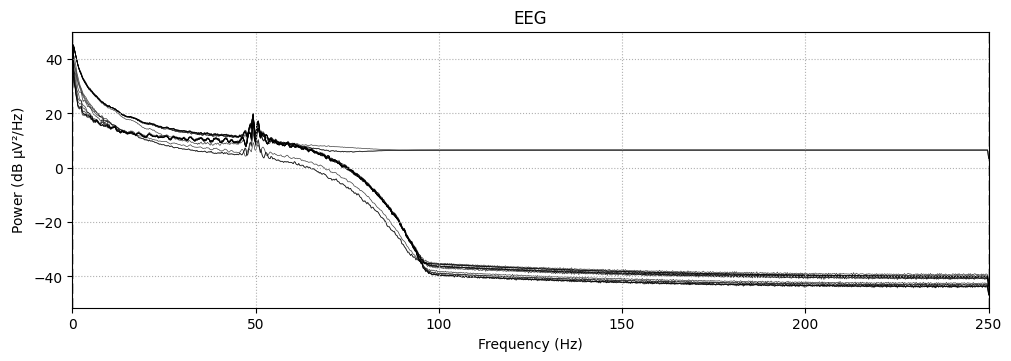

In [10]:
raw.compute_psd().plot()

# Events searching

In [11]:
raw_events = mne.events_from_annotations(raw)

events_from_raw = []
for event in raw_events[0][1:-1]:
    events_from_raw.append([event[0], event[-1]])

events_from_raw

Used Annotations descriptions: [np.str_('pointPolySomnographyPatientLieDownSpine'), np.str_('Закрывание глаз (testUser)'), np.str_('Открывание глаз (testUser)'), np.str_('Фоновая запись (testUser)')]


[[np.int64(7548), np.int64(1)],
 [np.int64(17072), np.int64(3)],
 [np.int64(63872), np.int64(2)],
 [np.int64(154144), np.int64(3)],
 [np.int64(196000), np.int64(2)],
 [np.int64(323936), np.int64(3)]]

In [12]:
events = []

mark_l = list(range(17072, 17072 + int(60.1 * 500), 500))
mark_r = list(range(154144, 154144 + int(60.1 * 500), 500))
for stamp in mark_l:
    events.append([stamp, 1])
for stamp in mark_r:
    events.append([stamp, 2])

events

[[17072, 1],
 [17572, 1],
 [18072, 1],
 [18572, 1],
 [19072, 1],
 [19572, 1],
 [20072, 1],
 [20572, 1],
 [21072, 1],
 [21572, 1],
 [22072, 1],
 [22572, 1],
 [23072, 1],
 [23572, 1],
 [24072, 1],
 [24572, 1],
 [25072, 1],
 [25572, 1],
 [26072, 1],
 [26572, 1],
 [27072, 1],
 [27572, 1],
 [28072, 1],
 [28572, 1],
 [29072, 1],
 [29572, 1],
 [30072, 1],
 [30572, 1],
 [31072, 1],
 [31572, 1],
 [32072, 1],
 [32572, 1],
 [33072, 1],
 [33572, 1],
 [34072, 1],
 [34572, 1],
 [35072, 1],
 [35572, 1],
 [36072, 1],
 [36572, 1],
 [37072, 1],
 [37572, 1],
 [38072, 1],
 [38572, 1],
 [39072, 1],
 [39572, 1],
 [40072, 1],
 [40572, 1],
 [41072, 1],
 [41572, 1],
 [42072, 1],
 [42572, 1],
 [43072, 1],
 [43572, 1],
 [44072, 1],
 [44572, 1],
 [45072, 1],
 [45572, 1],
 [46072, 1],
 [46572, 1],
 [47072, 1],
 [154144, 2],
 [154644, 2],
 [155144, 2],
 [155644, 2],
 [156144, 2],
 [156644, 2],
 [157144, 2],
 [157644, 2],
 [158144, 2],
 [158644, 2],
 [159144, 2],
 [159644, 2],
 [160144, 2],
 [160644, 2],
 [161144, 2

# Segmentation

In [13]:
sample_rate = raw.info['sfreq']
win = np.arange(int(0.0 * sample_rate), int(0.2 * sample_rate))
len(win)

100

In [14]:
trials = []

for event in events:
    for i in win:
        row = []
        for j in range(20):
            if j < 19:
                row.append(data[event[0] + i][j] * 1e6)
            else:
                row.append(event[1])
        trials.append(row)

trials = np.array(trials)

trials_df = pd.DataFrame(trials, columns=final_columns)

In [56]:
dataset_l:np.ndarray = trials[:6100]
dataset_l:np.ndarray = np.delete(dataset_l, np.s_[-1], axis=1)

dataset_r:np.ndarray = trials[6100:]
dataset_r:np.ndarray = np.delete(dataset_r, np.s_[-1], axis=1)

windows_l:np.ndarray = dataset_l.T.reshape(19, 100, 61)
y_l:np.ndarray = np.zeros((61, 1))

windows_r:np.ndarray = dataset_r.T.reshape(19, 100, 61)
y_r:np.ndarray = np.ones((61, 1))

# Logvar fuction and computing variances

In [116]:
def logvar(x, axis=0):
    return np.log(np.var(x, axis=axis))

In [17]:
variances = []

trials_df_l = trials_df[trials_df['mark'] == 1]
trials_df_r = trials_df[trials_df['mark'] == 2]

l_var = []
for col in final_columns[:-1]:
    l_var.append(logvar(trials_df_l[col]))
l_var.append(1.0)

variances.append(l_var)

r_var = []
for col in final_columns[:-1]:
    r_var.append(logvar(trials_df_r[col]))
r_var.append(2.0)

variances.append(r_var)

In [18]:
variances = pd.DataFrame(variances, columns=final_columns)

variances.iloc[0] - variances.iloc[1]

FP1    -0.057528
FP2    -0.257527
F3      0.181321
F4     -0.194844
C3      0.153904
C4     -0.164544
P3      0.081965
P4     -0.142431
O1      0.185493
O2     -0.115265
F7      0.326064
F8     -0.042507
T3      0.081123
T4      0.019215
T5      0.004378
T6     -0.100383
Fz     -0.154836
Cz     -0.662446
Pz     -0.214768
mark   -1.000000
dtype: float64

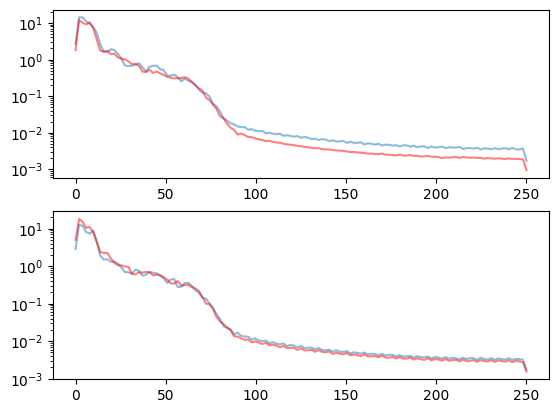

In [58]:
f1, Pxx_den1 = signal.welch(windows_l[4, :, :].reshape(6100,), sample_rate, nperseg=256)
f2, Pxx_den2 = signal.welch(windows_r[4, :, :].reshape(6100,), sample_rate, nperseg=256)

f1_2, Pxx_den1_2 = signal.welch(trials_df_l['C4'], sample_rate, nperseg=256)
f2_2, Pxx_den2_2 = signal.welch(trials_df_r['C4'], sample_rate, nperseg=256)

fig, ax = plt.subplots(2)

ax[0].semilogy(f1, Pxx_den1, alpha=0.5)
ax[0].semilogy(f2, Pxx_den2, c='red', alpha=0.5)

"""ax[0].xlabel('frequency [Hz]')
ax[0].ylabel('PSD $[V^2/Hz]$')"""

ax[1].semilogy(f1_2, Pxx_den1_2, alpha=0.5)
ax[1].semilogy(f2_2, Pxx_den2_2, c='red', alpha=0.5)

"""ax[1].xlabel('frequency [Hz]')
ax[1].ylabel('PSD $[V^2/Hz]$')"""

plt.savefig('holy_c.jpg')
plt.show()

# CSP and postprocessing

In [60]:
def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((trials.shape[0], trials.shape[1], ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

In [63]:
def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / trials.shape[1] for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    nchannels = trials.shape[0]
    nsamples = trials.shape[1]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [94]:
trials_filt = {'left': bandpass(windows_l, 2, 15, sample_rate),
               'right': bandpass(windows_r, 2, 15, sample_rate)}

In [95]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    
    ntrials = trials.shape[2]
    nchannels = trials.shape[0]
    nsamples = trials.shape[1]
    trials_PSD = np.zeros((nchannels, 51, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [97]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials_filt.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()
    plt.show()

In [98]:
psd_r, freqs = psd(trials_filt['left'])
psd_f, freqs = psd(trials_filt['right'])
trials_PSD = {'left': psd_r, 'right': psd_f}

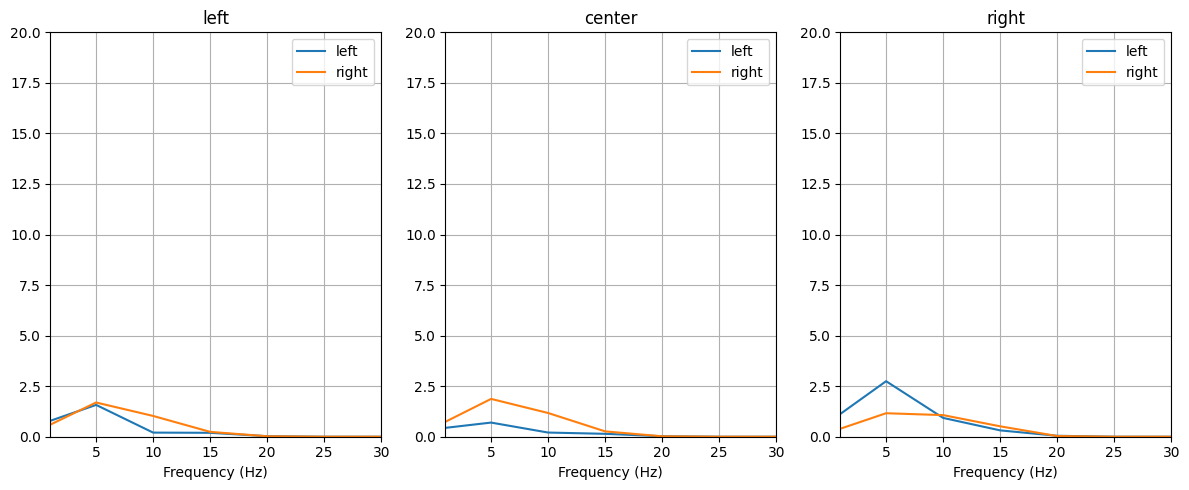

In [100]:
plot_psd(
    trials_PSD,
    freqs,
    [4, 17, 5],
    chan_lab=['left', 'center', 'right'],
    maxy=20
)

In [106]:
W = csp(trials_filt['left'], trials_filt['right'])
trials_csp = {'left': apply_mix(W, trials_filt['left']),
              'right': apply_mix(W, trials_filt['right'])}

In [117]:
trials_logvar = {'left': logvar(trials_csp['left'], axis=1),
                 'right': logvar(trials_csp['right'], axis=1)}

trials_logvar

{'left': array([[-3.99843319, -3.68519842, -3.47078302, ..., -4.00704225,
         -4.3925805 , -3.52842209],
        [-0.64042941, -1.06007414, -1.77726057, ..., -2.77610667,
         -3.14590298, -2.82295821],
        [-2.46988342, -2.8102318 , -2.0418585 , ..., -1.37443312,
         -2.02774287, -1.9682454 ],
        ...,
        [ 0.40552505,  0.43730223,  0.51942394, ..., -3.13037414,
         -2.08487086, -1.85226363],
        [ 0.17658122,  0.31431601, -0.14309507, ..., -0.45341793,
         -0.48666199, -0.40770125],
        [-0.49781222, -0.88682038, -0.51146188, ..., -0.76404538,
         -1.44998601, -1.59207118]]),
 'right': array([[ 0.27171981,  0.11317216,  0.22070205, ..., -0.86537236,
         -0.79189172, -1.00514974],
        [-0.8582432 , -1.00574173, -0.94636832, ..., -0.28032573,
         -0.40974892, -0.7628047 ],
        [ 0.04396068, -0.23897116, -0.00475924, ..., -0.70381515,
         -0.91860968, -0.45043205],
        ...,
        [-1.79857072, -1.79754194, -1

In [110]:
def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))
    nchannels = trials_filt['left'].shape[0]

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials['left'], axis=1)
    y1 = np.mean(trials['right'], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(['left', 'rigth'])
    plt.show()

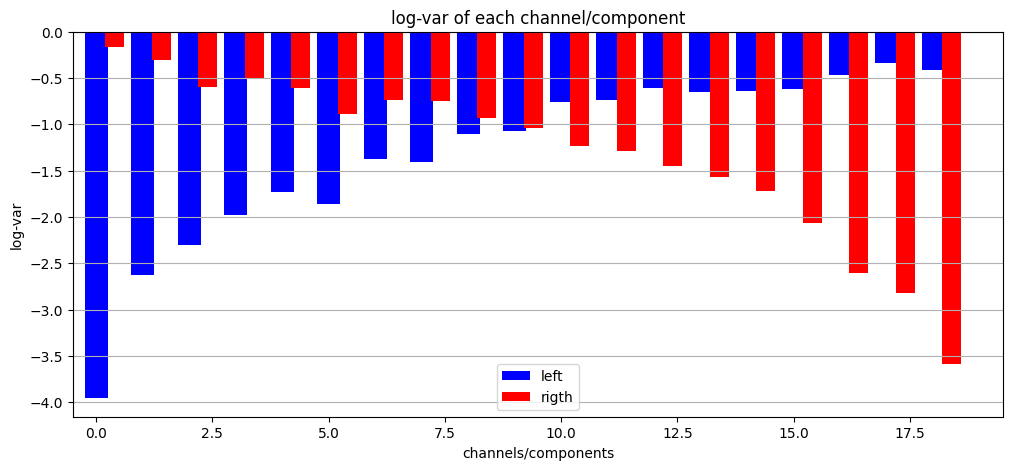

In [118]:
plot_logvar(trials_logvar)